# Exploratory Data Analytics
---
### Loading the dataset
We start by loading the dataset from the CSV file using pandas.
This file contains the historical daily prices of the S&P 500 index.

In [2]:
import pandas as pd
df = pd.read_csv("../data/SPX.csv")

---

### Missing values & Duplicated rows


In [3]:
print("Missing values per column:\n", df.isnull().sum())

print("Number of duplicated rows:", df.duplicated().sum())

Missing values per column:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Number of duplicated rows: 0


The dataset contains **no missing values** or duplicated rows, which means the data is complete and consistent.
We can proceed without applying any cleaning operations for these aspects.

---

### Basic DataFrame information & descriptive statistics 

In [4]:
print(df.info())

print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23323 entries, 0 to 23322
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       23323 non-null  object 
 1   Open       23323 non-null  float64
 2   High       23323 non-null  float64
 3   Low        23323 non-null  float64
 4   Close      23323 non-null  float64
 5   Adj Close  23323 non-null  float64
 6   Volume     23323 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.2+ MB
None
               Open          High           Low         Close     Adj Close  \
count  23323.000000  23323.000000  23323.000000  23323.000000  23323.000000   
mean     486.821737    489.690119    483.762812    486.918598    486.918598   
std      726.187716    730.112168    721.890344    726.278798    726.278798   
min        4.400000      4.400000      4.400000      4.400000      4.400000   
25%       23.855001     23.855001     23.855001     23.855001     23.8

The dataset contains **23,323 rows** with no missing values. The `Date` column is still stored as an object and will need to be converted to datetime for proper time-series analysis. The descriptive statistics show a wide range in price levels and high variability, reflecting the long historical span of the data. Volume also displays large dispersion, with zeros in the earliest years when reliable volume data was not available.

---

### Converting `Date` to datetime and verifying ascending order

In [5]:
df["Date"] = pd.to_datetime(df["Date"])
df["Date"].is_monotonic_increasing

True

### Stablishing `Date` as index

In [6]:
df = df.set_index("Date")
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


---

### Visualizing the historical S&P 500 price

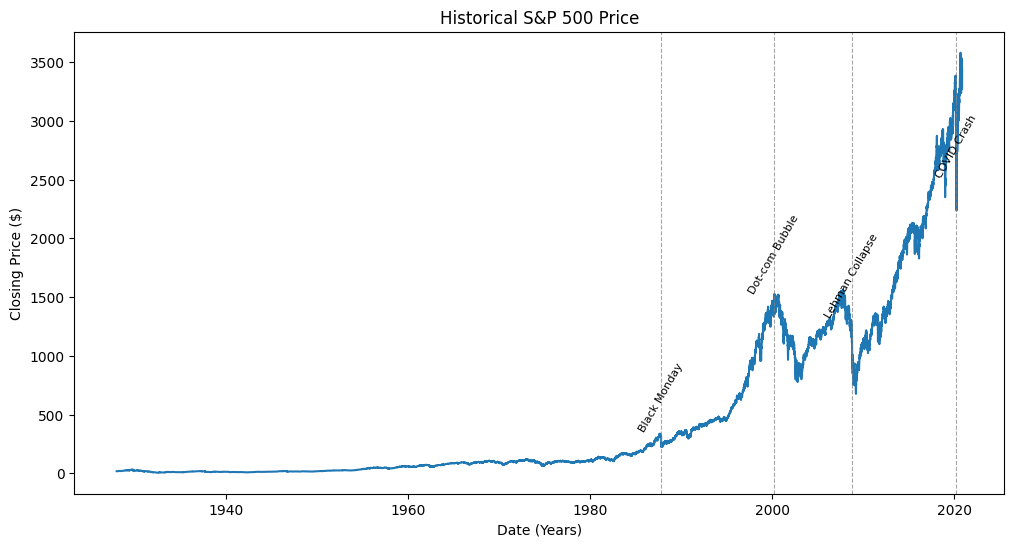

In [14]:
import matplotlib.pyplot as plt

COLORS = {
    "price": "#1f77b4",
    "volume": "#7f7f7f",
    "returns": "#2ca02c",
    "volatility": "#d62728"
}

crisis_dates = [
    ("1987-10-19", "Black Monday"),
    ("2000-03-10", "Dot-com Bubble"),
    ("2008-09-15", "Lehman Collapse"),
    ("2020-03-16", "COVID Crash"),
]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.index, df["Close"], color=COLORS["price"])

for date_str, label in crisis_dates:

    date = pd.to_datetime(date_str)

    ax.axvline(date, linestyle="--", color="gray", linewidth=0.8, alpha=0.7)

    y_pos = df["Close"].loc[date_str]

    ax.annotate(
        label,
        xy=(date, y_pos),
        xytext=(0, 10),
        textcoords="offset points",
        rotation=60,
        va="bottom",
        ha="center",
        fontsize=8,
        color="black"
    )

ax.set_title("Historical S&P 500 Price")
ax.set_xlabel("Date (Years)")
ax.set_ylabel("Closing Price ($)")
plt.show()

The S&P 500 displays a persistent long-term growth trend despite several major downturns. The annotated crisis dates mark periods of significant market stress, such as the dot-com bubble, the 2008 financial crisis and the COVID-19 shock.